# Sector-Coupling with `pypsa`

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

:::{note}
Also in this tutorial, you might want to refer to the PyPSA documentation: https://pypsa.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa pandas numpy matplotlib highspy
```
:::

In [6]:
pip install pypsa pandas numpy matplotlib highspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.1
    Uninstalling shapely-2.1.1:
      Successfully uninstalled shapely-2.1.1


In [7]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("bmh")

## Previous Capacity Expansion Model

To explore sector-coupling options with PyPSA, let's load the capacity expansion model we built for the electricity system and add sector-coupling technologies and demands on top.

This example has single node for Germany and 4-hourly temporal resolution for a year. It has wind and solar solar generation, an OCGT generator as well as battery and hydrogen storage to supply a fixed electricity demand.

Some sector-coupling technologies have multiple ouputs (e.g. CHP plants producing heat and power). PyPSA can automatically handle links have more than one input (`bus0`)
and/or output (i.e. `bus1`, `bus2`, `bus3`) with a given efficieny (`efficiency`, `efficiency2`, `efficiency3`).

In [8]:
url = "https://tubcloud.tu-berlin.de/s/pzytNg9gtkgPpXc/download/network-cem.nc"
n = pypsa.Network(url)

In [9]:
n

Unnamed PyPSA Network
---------------------
Components:
 - Bus: 1
 - Carrier: 6
 - Generator: 4
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
Snapshots: 2190

In [10]:
n.buses.index

Index(['electricity'], dtype='object', name='Bus')

In [11]:
n.generators.index

Index(['OCGT', 'onwind', 'offwind', 'solar'], dtype='object', name='Generator')

In [12]:
n.storage_units.index

Index(['battery storage', 'hydrogen storage underground'], dtype='object', name='StorageUnit')

## Hydrogen Production

The following example shows how to model the components of hydrogen storage separately, i.e. electrolysis, fuel cell and storage.

First, let's remove the simplified hydrogen storage representation:

In [13]:
n.remove("StorageUnit", "hydrogen storage underground")

Add a separate `Bus` for the hydrogen energy carrier:

In [14]:
n.add("Bus", "hydrogen")

Index(['hydrogen'], dtype='object')

Add a `Link` for the hydrogen electrolysis:

In [15]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier="electrolysis",
    p_nom_extendable=True,
    efficiency=0.7,
    capital_cost=50e3,  # €/MW/a
)

Index(['electrolysis'], dtype='object')

Add a `Link` for the fuel cell which reconverts hydrogen to electricity:

In [16]:
n.add(
    "Link",
    "fuel cell",
    bus0="hydrogen",
    bus1="electricity",
    carrier="fuel cell",
    p_nom_extendable=True,
    efficiency=0.5,
    capital_cost=120e3,  # €/MW/a
)

Index(['fuel cell'], dtype='object')

Add a `Store` for the hydrogen storage:

In [17]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier="hydrogen storage",
    capital_cost=140,  # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True,  # cyclic state of charge
)

Index(['hydrogen storage'], dtype='object')

We can also add a hydrogen demand to the hydrogen bus.

In the example below, we add a constant hydrogen demand the size of the electricity demand.

In [18]:
p_set = n.loads_t.p_set["demand"].mean()

In [19]:
p_set

np.float64(54671.88812785388)

In [20]:
n.add("Load", "hydrogen demand", bus="hydrogen", carrier="hydrogen", p_set=p_set)  # MW

Index(['hydrogen demand'], dtype='object')

## Heat Demand

For the heat demand, we create another bus and connect a load with the heat demand time series to it:

In [21]:
n.add("Bus", "heat")

Index(['heat'], dtype='object')

In [22]:
url = "https://tubcloud.tu-berlin.de/s/mSkHERH8fJCKNXx/download/heat-load-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

In [23]:
p_set.head()

,0
snapshot,
2015-01-01 00:00:00,61726.043437
2015-01-01 04:00:00,108787.133591
2015-01-01 08:00:00,101508.988082
2015-01-01 12:00:00,90475.260586
2015-01-01 16:00:00,96307.755312


In [24]:
n.add("Load", "heat demand", carrier="heat", bus="heat", p_set=p_set)

Index(['heat demand'], dtype='object')

<Axes: xlabel='snapshot', ylabel='GW'>

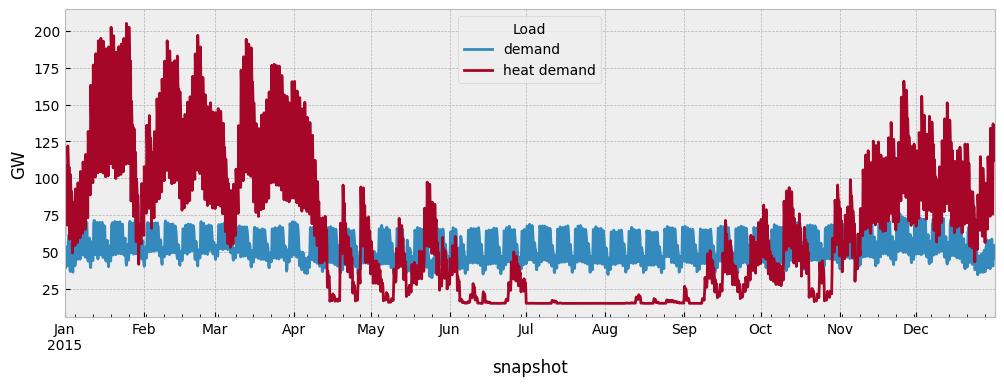

In [25]:
n.loads_t.p_set.div(1e3).plot(figsize=(12, 4), ylabel="GW")

## Heat pumps

To model heat pumps, first we have to calculate the **coefficient of performance (COP)** profile based on the temperature profile of the heat source.

In the example below, we calculate the COP for an air-sourced heat pump with a sink temperature of 55° C and a population-weighted ambient temperature profile for Germany.

The heat pump performance is given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063^\Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.

In [26]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.000630 * delta_t**2

In [27]:
url = "https://tubcloud.tu-berlin.de/s/S4jRAQMP5Te96jW/download/ninja_weather_country_DE_merra-2_population_weighted.csv"
temp = pd.read_csv(url, skiprows=2, index_col=0, parse_dates=True).loc[
    "2015", "temperature"
][::4]

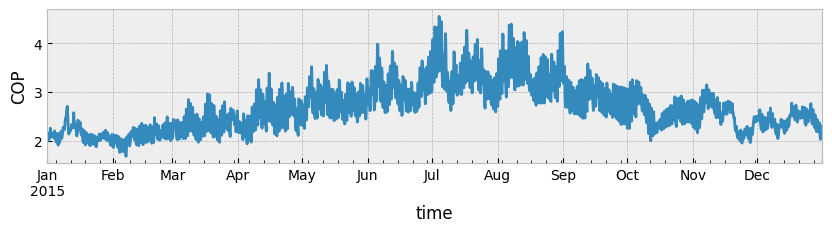

In [28]:
cop(temp).plot(figsize=(10, 2), ylabel="COP");

Text(0, 0.5, 'COP [-]')

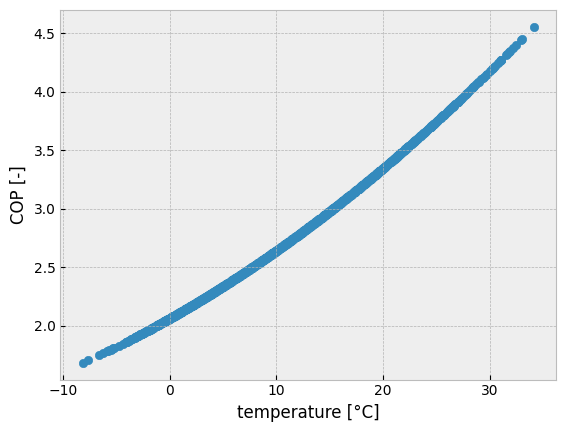

In [29]:
plt.scatter(temp, cop(temp))
plt.xlabel("temperature [°C]")
plt.ylabel("COP [-]")

Once we have calculated the heat pump coefficient of performance, we can add the heat pump to the network as a `Link`. We use the parameter `efficiency` to incorporate the COP.

In [30]:
n.add(
    "Link",
    "heat pump",
    carrier="heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp),
    p_nom_extendable=True,
    capital_cost=3e5,  # €/MWe/a
)

Index(['heat pump'], dtype='object')

Let's also add a resistive heater as backup technology:

In [31]:
n.add(
    "Link",
    "resistive heater",
    carrier="resistive heater",
    bus0="electricity",
    bus1="heat",
    efficiency=0.9,
    capital_cost=1e4,  # €/MWe/a
    p_nom_extendable=True,
)

Index(['resistive heater'], dtype='object')

## Combined Heat-and-Power (CHP)

In the following, we are going to add gas-fired combined heat-and-power plants (CHPs). Today, these would use fossil gas, but in the example below we assume green methane with relatively high marginal costs. Since we have no other net emission technology, we can remove the CO$_2$ limit.

In [32]:
n.remove("GlobalConstraint", "CO2Limit")

Then, we explicitly represent the energy carrier gas:

In [33]:
n.add("Bus", "gas", carrier="gas")

Index(['gas'], dtype='object')

And add a `Store` of gas, which can be depleted (up to 100 TWh) with fuel costs of 150 €/MWh.

In [34]:
n.add(
    "Store",
    "gas storage",
    carrier="gas storage",
    e_initial=100e6,  # MWh
    e_nom=100e6,  # MWh
    bus="gas",
    marginal_cost=150,  # €/MWh_th
)

Index(['gas storage'], dtype='object')

When we do this, we have to model the OCGT power plant as link which converts gas to electricity, not as generator.

In [35]:
n.remove("Generator", "OCGT")

In [36]:
n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    carrier="OCGT",
    p_nom_extendable=True,
    capital_cost=20000,  # €/MW/a
    efficiency=0.4,
)

Index(['OCGT'], dtype='object')

Next, we are going to add a combined heat-and-power (CHP) plant with fixed heat-power ratio (i.e. backpressure operation). If you want to model flexible heat-power ratios, have a look at this example: https://pypsa.readthedocs.io/en/latest/examples/power-to-gas-boiler-chp.html

In [37]:
n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    carrier="CHP",
    p_nom_extendable=True,
    capital_cost=40000,
    efficiency=0.4,
    efficiency2=0.4,
)

Index(['CHP'], dtype='object')

## Electric Vehicles

To model electric vehicles, we first create another bus for the electric vehicles.

In [38]:
n.add("Bus", "EV", carrier="EV")

Index(['EV'], dtype='object')

Then, we can attach the electricity consumption of electric vehicles to this bus:

In [39]:
url = "https://tubcloud.tu-berlin.de/s/9r5bMSbzzQiqG7H/download/electric-vehicle-profile-example.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

<Axes: xlabel='snapshot', ylabel='GW'>

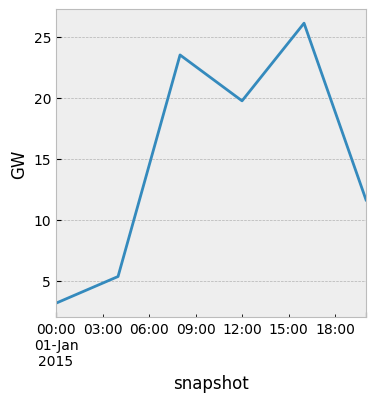

In [40]:
p_set.loc["2015-01-01"].div(1e3).plot(figsize=(4, 4), ylabel="GW")

In [41]:
n.add("Load", "EV demand", bus="EV", carrier="EV demand", p_set=p_set)

Index(['EV demand'], dtype='object')

Let's have a quick look at how the heat, electricity, constant hydrogen and electric vehicle demands relate to each other:

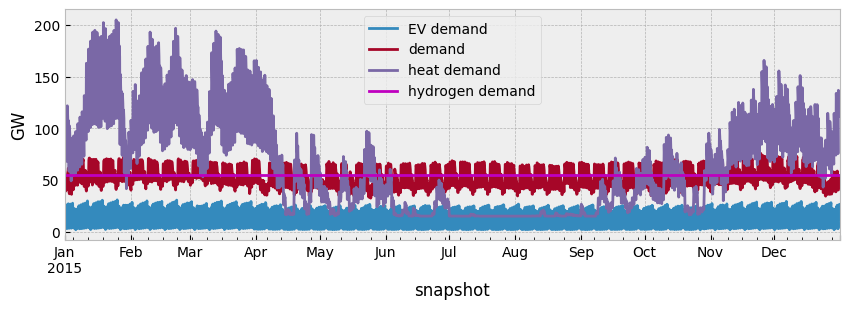

In [42]:
n.loads_t.p_set.div(1e3).plot(figsize=(10, 3), ylabel="GW")
plt.axhline(
    n.loads.loc["hydrogen demand", "p_set"] / 1e3, label="hydrogen demand", color="m"
)
plt.legend()

The electric vehicles can only be charged when they are plugged-in. Below we load an availability profile
telling us what share of electric vehicles is plugged-in **at home** -- we only assume home charging in this example.

In [43]:
url = "https://tubcloud.tu-berlin.de/s/E3PBWPfYaWwCq7a/download/electric-vehicle-availability-example.csv"
availability_profile = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

<Axes: xlabel='snapshot'>

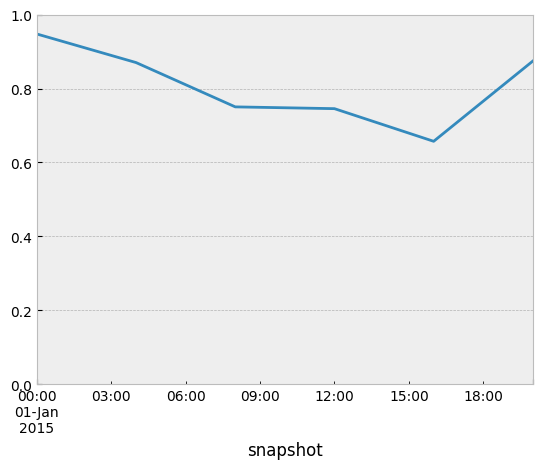

In [44]:
availability_profile.loc["2015-01-01"].plot(ylim=(0, 1))

Then, we can add a link for the electric vehicle charger using assumption about the number of EVs and their charging rates.

In [45]:
number_cars = 40e6  #  number of EV cars
bev_charger_rate = 0.011  # 3-phase EV charger with 11 kW
p_nom = number_cars * bev_charger_rate

In [46]:
n.add(
    "Link",
    "EV charger",
    bus0="electricity",
    bus1="EV",
    p_nom=p_nom,
    carrier="EV charger",
    p_max_pu=availability_profile,
    efficiency=0.9,
)

Index(['EV charger'], dtype='object')

We can also allow vehicle-to-grid operation (i.e. electric vehicles inject power into the grid):

In [47]:
n.add(
    "Link",
    "V2G",
    bus0="EV",
    bus1="electricity",
    p_nom=p_nom,
    carrier="V2G",
    p_max_pu=availability_profile,
    efficiency=0.9,
)

Index(['V2G'], dtype='object')

The demand-side management potential we model as a store. This is not unlike a battery storage, but we impose additional constraints on when the store needs to be charged to a certain level (e.g. 75% full every morning).

In [48]:
bev_energy = 0.05  # average battery size of EV in MWh
bev_dsm_participants = 0.5  # share of cars that do smart charging

e_nom = number_cars * bev_energy * bev_dsm_participants

In [49]:
url = "https://tubcloud.tu-berlin.de/s/K62yACBRTrxLTia/download/dsm-profile-example.csv"
dsm_profile = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()

<Axes: xlabel='snapshot'>

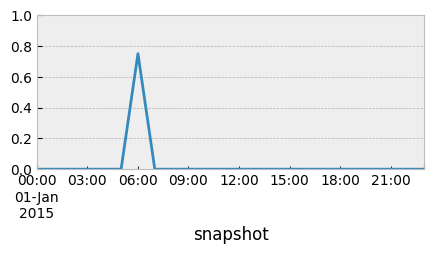

In [50]:
dsm_profile.loc["2015-01-01"].plot(figsize=(5, 2), ylim=(0, 1))

In [52]:
n.add(
    "Store",
    "EV DSM",
    bus="EV",
    carrier="EV battery",
    e_cyclic=True,  # state of charge at beginning = state of charge at the end
    e_nom=e_nom,
    e_min_pu=dsm_profile,
)

ValueError: Series e_min_pu has an index which does not align with the passed network snapshots.

Then, we can solve the fully sector-coupled model altogether including electricity, passenger transport, hydrogen and heating.

In [53]:
n.optimize(solver_name="highs")

Index(['electricity', 'hydrogen', 'heat', 'gas', 'EV'], dtype='object', name='Bus')
Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP',
       'EV charger', 'V2G'],
      dtype='object', name='Link')
Index(['hydrogen demand', 'heat demand', 'EV demand'], dtype='object', name='Load')
Index(['hydrogen storage', 'gas storage'], dtype='object', name='Store')
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 114.01it/s]


('ok', 'optimal')

In [54]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   offwind               2.358228e+05                 0.0   
            onwind                1.701380e+05                 0.0   
            solar                 5.110646e+05                 0.0   
Link        CHP                   1.966081e+05                 0.0   
            EV charger            4.400000e+05            440000.0   
            V2G                   4.400000e+05            440000.0   
            electrolysis          1.843041e+05                 0.0   
            fuel cell             1.421965e+04                 0.0   
            heat pump             5.314329e+04                 0.0   
            resistive heater      7.876871e+04                 0.0   
Load        -                     0.000000e+00                 0.0   
            EV demand             0.000000e+00                 0.0   
            heat                  0.000000e+00                 0.0   
            hydrogen              0.000000e+00                 0.0   
StorageUnit battery storage       9.675915e+04                 0.0   
Store       gas storage           1.000000e+08         100000000.0   
            hydrogen storage      5.471364e+07                 0.0   

                                    Supply    Withdrawal  Energy Balance  \
Generator   offwind           7.325136e+08  0.000000e+00    7.325136e+08   
            onwind            2.513656e+08  0.000000e+00    2.513656e+08   
            solar             5.554276e+08  0.000000e+00    5.554276e+08   
Link        CHP               0.000000e+00  1.000000e+08   -1.000000e+08   
            EV charger        0.000000e+00  1.380862e+08   -1.380862e+08   
            V2G               0.000000e+00  0.000000e+00    0.000000e+00   
            electrolysis      0.000000e+00  7.088323e+08   -7.088323e+08   
            fuel cell         0.000000e+00  1.725690e+07   -1.725690e+07   
            heat pump         0.000000e+00  2.190906e+08   -2.190906e+08   
            resistive heater  0.000000e+00  3.433782e+07   -3.433782e+07   
Load        -                 0.000000e+00  4.789257e+08   -4.789257e+08   
            EV demand         0.000000e+00  1.242776e+08   -1.242776e+08   
            heat              0.000000e+00  5.936692e+08   -5.936692e+08   
            hydrogen          0.000000e+00  4.789257e+08   -4.789257e+08   
StorageUnit battery storage   1.018286e+08  1.104911e+08   -8.662505e+06   
Store       gas storage       1.000000e+08  0.000000e+00    1.000000e+08   
            hydrogen storage  2.277044e+08  2.277044e+08    0.000000e+00   

                              Transmission  Capacity Factor   Curtailment  \
Generator   offwind           0.000000e+00         0.354589  1.694311e+07   
            onwind            0.000000e+00         0.168655  5.527490e+07   
            solar             0.000000e+00         0.124065  5.433659e+05   
Link        CHP               1.000000e+08         0.058062  0.000000e+00   
            EV charger        0.000000e+00         0.035826  0.000000e+00   
            V2G               0.000000e+00         0.000000  0.000000e+00   
            electrolysis      7.088323e+08         0.439040  0.000000e+00   
            fuel cell         1.725690e+07         0.138538  0.000000e+00   
            heat pump         2.190906e+08         0.470621  0.000000e+00   
            resistive heater  3.433782e+07         0.049764  0.000000e+00   
Load        -                 0.000000e+00              NaN  0.000000e+00   
            EV demand         0.000000e+00              NaN  0.000000e+00   
            heat              0.000000e+00              NaN  0.000000e+00   
            hydrogen          0.000000e+00              NaN  0.000000e+00   
StorageUnit battery storage   0.000000e+00         0.250492  8.562726e+08   
Store       gas storage       0.000000e+00         0.283805  0.000000e+00   
            hydrogen storage  0.000000e+00         0.507602  0.000000e+00   

             

<Axes: ylabel='bn€/a'>

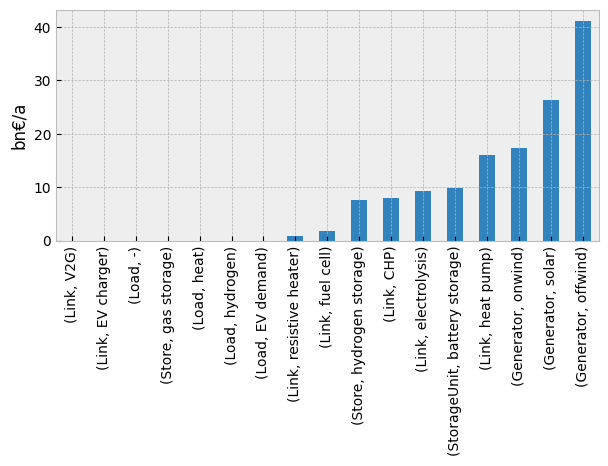

In [55]:
n.statistics()["Capital Expenditure"].div(1e9).sort_values().dropna().plot.bar(
    ylabel="bn€/a", cmap="tab20c", figsize=(7, 3)
)

## Exercises

Here are a few things you can do to explore this system:

- exclude one of transport sector, heating sector, hydrogen demand and investigate what impact it has on system operation and investments
- vary the charging rates and availability profiles of electric vehicles